In [11]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
MODEL_PATH = 'model.h5'
if os.path.exists(MODEL_PATH):
    print(f"Model already exists at {MODEL_PATH}. Skipping training.")
    exit(0)


In [3]:
# Load MNIST dataset
data = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = data.load_data()

In [4]:
# Normalize and reshape
def preprocess(x):
    x = x.astype('float32') / 255.0
    return np.expand_dims(x, -1)


In [5]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Build model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 26s 8ms/step - loss: 0.1390 - accuracy: 0.9569 - val_loss: 0.0500 - val_accuracy: 0.9836
Epoch 2/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0459 - accuracy: 0.9856 - val_loss: 0.0384 - val_accuracy: 0.9870
Epoch 3/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0322 - accuracy: 0.9893 - val_loss: 0.0320 - val_accuracy: 0.9887
Epoch 4/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0230 - accuracy: 0.9927 - val_loss: 0.0311 - val_accuracy: 0.9893
Epoch 5/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0186 - accuracy: 0.9941 - val_loss: 0.0433 - val_accuracy: 0.9877


In [7]:
# Evaluate
loss, acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {acc:.4f}")

# Predict on test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)


313/313 - 1s - loss: 0.0433 - accuracy: 0.9877 - 1s/epoch - 4ms/step
Test accuracy: 0.9877
313/313 [==============================] - 1s 3ms/step


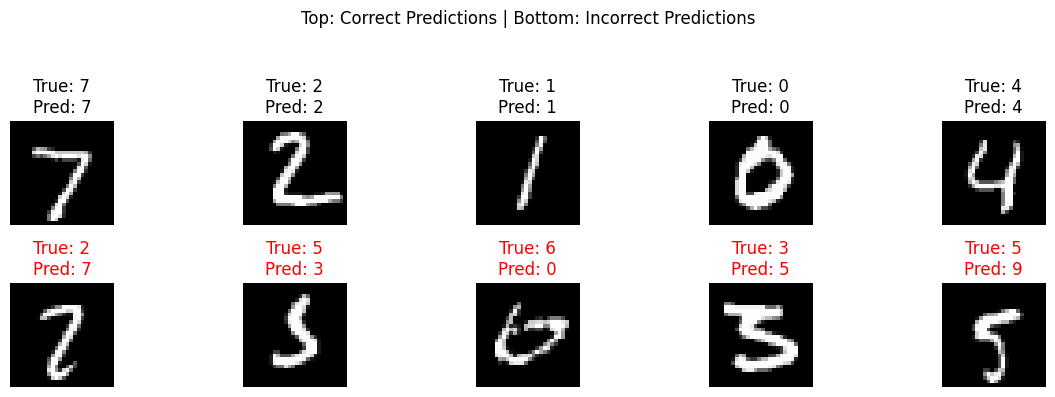

Model saved to model.h5


In [8]:
# Show some correct and incorrect predictions
num_examples = 10
correct = np.where(y_pred == y_test)[0]
incorrect = np.where(y_pred != y_test)[0]

plt.figure(figsize=(12, 4))
for i, idx in enumerate(correct[:5]):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f"True: {y_test[idx]}\nPred: {y_pred[idx]}")
    plt.axis('off')
for i, idx in enumerate(incorrect[:5]):
    plt.subplot(2, 5, 6+i)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f"True: {y_test[idx]}\nPred: {y_pred[idx]}", color='red')
    plt.axis('off')
plt.suptitle('Top: Correct Predictions | Bottom: Incorrect Predictions')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

# Save model
model.save(MODEL_PATH)
print(f"Model saved to {MODEL_PATH}") 

In [9]:
MODEL_PATH = 'model.h5'
# Load the trained model
model = tf.keras.models.load_model(MODEL_PATH)


In [13]:
# Start webcam
cap = cv2.VideoCapture(0)
pred_digit = None

print("Press SPACE to capture and predict a digit. Press ESC to exit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    display_frame = frame.copy()
    if pred_digit is not None:
        cv2.putText(display_frame, f"Predicted: {pred_digit}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)

    cv2.imshow('Camera - SPACE: predict, ESC: exit', display_frame)
    key = cv2.waitKey(1)

    if key % 256 == 27:  # ESC pressed
        print("Exiting...")
        break
    elif key % 256 == 32:  # SPACE pressed
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        min_dim = min(h, w)
        start_x = w//2 - min_dim//2
        start_y = h//2 - min_dim//2
        gray = gray[start_y:start_y+min_dim, start_x:start_x+min_dim]
        # Resize to 28x28
        resized = cv2.resize(gray, (28, 28), interpolation=cv2.INTER_AREA)
        # Adaptive thresholding for any background
        thresh = cv2.adaptiveThreshold(resized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        # Check if digit is black or white (MNIST expects white digit)
        if np.mean(thresh) > 127:
            # Background is white, digit is black, so invert
            thresh = 255 - thresh
        # Normalize and reshape
        input_img = thresh.astype('float32') / 255.0
        input_img = np.expand_dims(input_img, axis=(0, -1))  # Shape: (1, 28, 28, 1)
        # Predict
        y_pred = model.predict(input_img)
        pred_digit = int(np.argmax(y_pred))
cap.release()
cv2.destroyAllWindows()
print("Camera released and windows closed.") 

Press SPACE to capture and predict a digit. Press ESC to exit.
1/1 [==============================] - 0s 16ms/step
Exiting...
Camera released and windows closed.
